# Part 2: PyTorch 2-Layer Neural Network Project

This notebook is the **Part 2** submission (Deep Learning Framework implementation).

Part 1 (from-scratch NumPy neural network) is already handled in `neural_network_experiments.ipynb` and `neural_network.py`.

## What this notebook covers
1. Task 1: Framework learning resources (with links and rationale)
2. Task 2: EDA, train-dev-test split, PyTorch 2-layer model, cost, gradient-based training, normalization experiment, and test results
3. Task 3: Hyperparameter selection rationale + random search tuning


## Task 1 - Resources Used to Learn PyTorch

These are the primary resources used to implement forward pass, backpropagation, loss, and optimizer updates for a 2-layer network:

1. PyTorch: Build the Neural Network
   - https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
   - Why: Establishes `nn.Module`, layer declaration, and `forward()` implementation pattern.

2. PyTorch: Automatic Differentiation with `torch.autograd`
   - https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
   - Why: Explains how gradients are tracked and propagated for backpropagation.

3. `nn.BCEWithLogitsLoss` API
   - https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
   - Why: Correct binary-classification loss with numerically stable sigmoid+cross-entropy.

4. `torch.optim` API
   - https://pytorch.org/docs/stable/optim.html
   - Why: Training updates with SGD, RMSprop, and Adam for optimizer comparison.

5. `torch.utils.data.DataLoader`
   - https://pytorch.org/docs/stable/data.html
   - Why: Mini-batch loading and shuffling for efficient training loops.

6. Saving train/eval behavior in modules
   - https://pytorch.org/docs/stable/generated/torch.nn.Module.html
   - Why: Uses `model.train()` and `model.eval()` correctly for training vs evaluation behavior.


In [14]:
from __future__ import annotations

import time
from typing import Dict

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

plt.style.use('ggplot')
np.set_printoptions(suppress=True, precision=4)

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)


Using device: cpu


In [15]:
SAMPLE_ROWS = 50000

con = duckdb.connect()
query = f"""
WITH trade_outcomes AS (
    SELECT
        t.count::DOUBLE AS trade_size,
        CASE WHEN t.taker_side = 'yes' THEN t.yes_price ELSE t.no_price END::DOUBLE / 100.0 AS entry_price,
        t.yes_price::DOUBLE / 100.0 AS yes_price,
        t.no_price::DOUBLE / 100.0 AS no_price,
        EXTRACT(hour FROM t.created_time)::DOUBLE AS hour_of_day,
        EXTRACT(dow FROM t.created_time)::DOUBLE AS day_of_week,
        CASE WHEN t.taker_side = 'yes' THEN 1 ELSE 0 END::DOUBLE AS took_yes,
        CASE WHEN t.taker_side = m.result THEN 1 ELSE 0 END::DOUBLE AS won
    FROM 'data/kalshi/trades/*.parquet' t
    JOIN 'data/kalshi/markets/*.parquet' m USING (ticker)
    WHERE m.status = 'finalized'
      AND m.result IN ('yes', 'no')
      AND t.count > 0
      AND t.yes_price BETWEEN 1 AND 99
      AND t.no_price BETWEEN 1 AND 99
)
SELECT *
FROM trade_outcomes
USING SAMPLE {SAMPLE_ROWS} ROWS (reservoir)
"""

df = con.execute(query).df()
df.head()


,trade_size,entry_price,yes_price,no_price,hour_of_day,day_of_week,took_yes,won
0,99.0,0.22,0.22,0.78,11.0,2.0,1.0,1.0
1,500.0,0.09,0.09,0.91,6.0,5.0,1.0,0.0
2,197.0,0.61,0.39,0.61,15.0,6.0,0.0,1.0
3,60.0,0.57,0.57,0.43,13.0,0.0,1.0,1.0
4,170.0,0.99,0.01,0.99,15.0,5.0,0.0,1.0


## Task 2 - Step 1: EDA and Cleaning

Inspect data quality, remove missing/duplicate rows, and examine feature distributions/correlations.


In [16]:
print('Initial shape:', df.shape)
print('\nDtypes:')
print(df.dtypes)

missing_before = int(df.isna().sum().sum())
dup_before = int(df.duplicated().sum())
print(f'\nMissing values before cleaning: {missing_before}')
print(f'Duplicate rows before cleaning: {dup_before}')

df = df.dropna().drop_duplicates().reset_index(drop=True)

missing_after = int(df.isna().sum().sum())
dup_after = int(df.duplicated().sum())
print(f'Missing values after cleaning:  {missing_after}')
print(f'Duplicate rows after cleaning: {dup_after}')
print('Final shape:', df.shape)

print('\nClass balance (won):')
print(df['won'].value_counts(normalize=True).rename('fraction'))

display(df.describe().T)


Initial shape: (50000, 8)

Dtypes:
trade_size     float64
entry_price    float64
yes_price      float64
no_price       float64
hour_of_day    float64
day_of_week    float64
took_yes       float64
won            float64
dtype: object

Missing values before cleaning: 0
Duplicate rows before cleaning: 1108
Missing values after cleaning:  0
Duplicate rows after cleaning: 0
Final shape: (48892, 8)

Class balance (won):
won
0.0    0.523214
1.0    0.476786
Name: fraction, dtype: float64


,count,mean,std,min,25%,50%,75%,max
trade_size,48892.0,250.805367,1276.121326,1.00,10.00,40.00,137.00,91758.00
entry_price,48892.0,0.486384,0.282242,0.01,0.25,0.49,0.71,0.99
yes_price,48892.0,0.445022,0.277170,0.01,0.21,0.43,0.65,0.99
no_price,48892.0,0.554951,0.277139,0.01,0.35,0.57,0.79,0.99
hour_of_day,48892.0,13.739548,4.918075,0.00,10.00,14.00,18.00,23.00
day_of_week,48892.0,3.088522,2.116375,0.00,1.00,3.00,5.00,6.00
took_yes,48892.0,0.689417,0.462737,0.00,0.00,1.00,1.00,1.00
won,48892.0,0.476786,0.499466,0.00,0.00,0.00,1.00,1.00


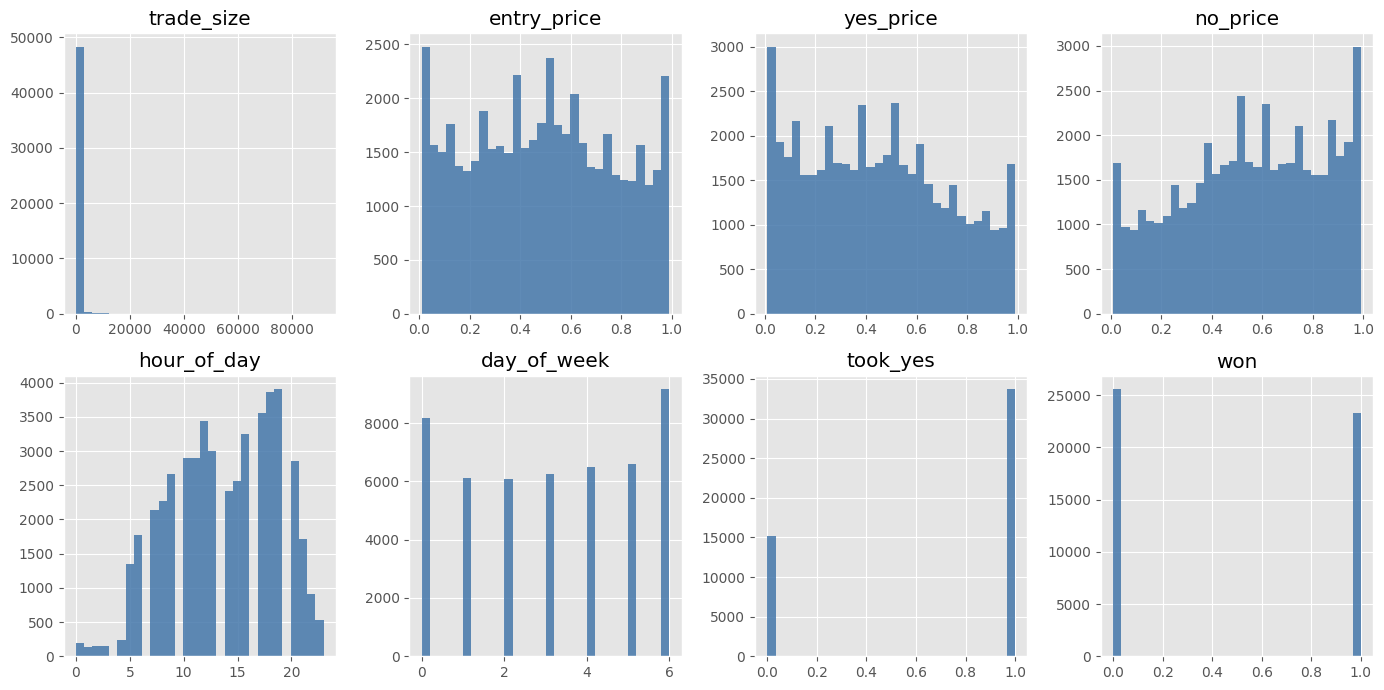

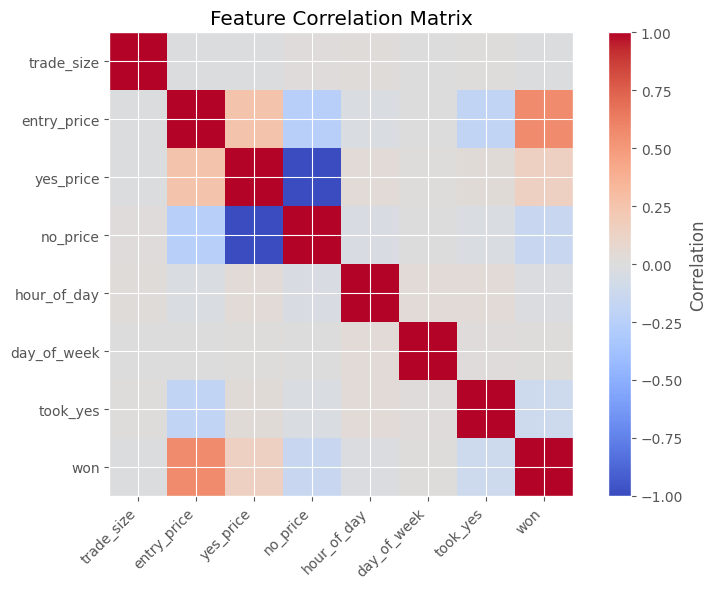

In [17]:
feature_columns = [
    'trade_size',
    'entry_price',
    'yes_price',
    'no_price',
    'hour_of_day',
    'day_of_week',
    'took_yes',
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()
for i, col in enumerate(feature_columns + ['won']):
    axes[i].hist(df[col], bins=30, color='#4477AA', alpha=0.85)
    axes[i].set_title(col)

for j in range(len(feature_columns) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

corr = df[feature_columns + ['won']].corr(numeric_only=True)
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Feature Correlation Matrix')
cbar = plt.colorbar()
cbar.set_label('Correlation')
plt.tight_layout()
plt.show()


## Task 2 - Step 2: Train-Dev-Test Split

Split is **70% train**, **15% dev**, **15% test**.

We keep both unnormalized and normalized feature matrices for the normalization experiment.


In [18]:
X_all = df[feature_columns].to_numpy(dtype=np.float64)
y_all = df['won'].to_numpy(dtype=np.float64).reshape(-1, 1)

n = X_all.shape[0]
indices = rng.permutation(n)

train_end = int(0.70 * n)
dev_end = int(0.85 * n)

train_idx = indices[:train_end]
dev_idx = indices[train_end:dev_end]
test_idx = indices[dev_end:]

X_train_raw = X_all[train_idx]
X_dev_raw = X_all[dev_idx]
X_test_raw = X_all[test_idx]

y_train = y_all[train_idx]
y_dev = y_all[dev_idx]
y_test = y_all[test_idx]

mu = X_train_raw.mean(axis=0, keepdims=True)
sigma = X_train_raw.std(axis=0, keepdims=True)
sigma[sigma == 0] = 1.0

X_train_norm = (X_train_raw - mu) / sigma
X_dev_norm = (X_dev_raw - mu) / sigma
X_test_norm = (X_test_raw - mu) / sigma

print('Train shape:', X_train_norm.shape, y_train.shape)
print('Dev shape:  ', X_dev_norm.shape, y_dev.shape)
print('Test shape: ', X_test_norm.shape, y_test.shape)


Train shape: (34224, 7) (34224, 1)
Dev shape:   (7334, 7) (7334, 1)
Test shape:  (7334, 7) (7334, 1)


## Task 2 - Steps 3, 4, 5: 2-Layer PyTorch Network, Cost, and Training

Model: 2-layer MLP (`Linear -> ReLU -> Linear`) for binary classification.

- Forward propagation: through two linear layers with ReLU hidden activation
- Cost: `BCEWithLogitsLoss`
- Gradient descent/optimization: SGD, RMSprop, Adam
- Regularization: L2 via optimizer `weight_decay`


In [19]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 32) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


def build_optimizer(name: str, params, lr: float, weight_decay: float):
    name = name.lower()
    if name == 'sgd':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    if name == 'rmsprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
    if name == 'adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    raise ValueError("optimizer must be one of: 'sgd', 'rmsprop', 'adam'")


def to_tensor_pair(X: np.ndarray, y: np.ndarray):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    return X_t, y_t


def classification_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    y_true = y_true.astype(int).reshape(-1)
    y_pred = y_pred.astype(int).reshape(-1)

    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))

    acc = (tp + tn) / max(1, tp + tn + fp + fn)
    precision = tp / max(1, tp + fp)
    recall = tp / max(1, tp + fn)
    f1 = 2 * precision * recall / max(1e-12, precision + recall)

    return {
        'accuracy': float(acc),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
    }


def evaluate_model(model: nn.Module, X: torch.Tensor, y: torch.Tensor) -> Dict[str, float]:
    loss_fn = nn.BCEWithLogitsLoss()
    model.eval()
    with torch.no_grad():
        logits = model(X.to(DEVICE))
        loss = float(loss_fn(logits, y.to(DEVICE)).item())
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)

    metrics = classification_metrics(y.cpu().numpy(), preds)
    metrics['loss'] = loss
    return metrics


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    X_dev_t: torch.Tensor,
    y_dev_t: torch.Tensor,
    optimizer,
    epochs: int = 60,
    print_every: int = 15,
):
    loss_fn = nn.BCEWithLogitsLoss()
    history = {'train_loss': [], 'dev_loss': []}

    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            batch_losses.append(float(loss.item()))

        train_loss = float(np.mean(batch_losses))

        model.eval()
        with torch.no_grad():
            dev_logits = model(X_dev_t.to(DEVICE))
            dev_loss = float(loss_fn(dev_logits, y_dev_t.to(DEVICE)).item())

        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)

        if print_every > 0 and (epoch == 1 or epoch % print_every == 0 or epoch == epochs):
            print(f'Epoch {epoch}/{epochs} - train loss: {train_loss:.6f} - dev loss: {dev_loss:.6f}')

    return history


def run_torch_experiment(
    label: str,
    optimizer_name: str,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_dev: np.ndarray,
    y_dev: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    hidden_dim: int = 32,
    learning_rate: float = 0.001,
    weight_decay: float = 1e-4,
    batch_size: int = 256,
    epochs: int = 60,
    print_every: int = 15,
    seed: int = RANDOM_SEED,
):
    torch.manual_seed(seed)

    X_train_t, y_train_t = to_tensor_pair(X_train, y_train)
    X_dev_t, y_dev_t = to_tensor_pair(X_dev, y_dev)
    X_test_t, y_test_t = to_tensor_pair(X_test, y_test)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    model = TwoLayerNN(input_dim=X_train.shape[1], hidden_dim=hidden_dim).to(DEVICE)
    optimizer = build_optimizer(optimizer_name, model.parameters(), learning_rate, weight_decay)

    start = time.perf_counter()
    history = train_model(
        model=model,
        train_loader=train_loader,
        X_dev_t=X_dev_t,
        y_dev_t=y_dev_t,
        optimizer=optimizer,
        epochs=epochs,
        print_every=print_every,
    )
    runtime = time.perf_counter() - start

    train_metrics = evaluate_model(model, X_train_t, y_train_t)
    dev_metrics = evaluate_model(model, X_dev_t, y_dev_t)
    test_metrics = evaluate_model(model, X_test_t, y_test_t)

    summary = {
        'label': label,
        'optimizer': optimizer_name,
        'hidden_dim': hidden_dim,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'epochs': epochs,
        'runtime_sec': float(runtime),
        'final_train_loss': train_metrics['loss'],
        'final_dev_loss': dev_metrics['loss'],
        'final_test_loss': test_metrics['loss'],
        'train_accuracy': train_metrics['accuracy'],
        'dev_accuracy': dev_metrics['accuracy'],
        'test_accuracy': test_metrics['accuracy'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],
        'test_f1': test_metrics['f1'],
        'history': history,
    }

    return model, summary


In [20]:
# Optimizer comparison on normalized features
optimizer_experiments = [
    {'label': 'SGD', 'optimizer': 'sgd', 'lr': 0.03},
    {'label': 'RMSprop', 'optimizer': 'rmsprop', 'lr': 0.001},
    {'label': 'Adam', 'optimizer': 'adam', 'lr': 0.001},
]

optimizer_results = []
optimizer_histories = {}

for exp in optimizer_experiments:
    print(f"\nRunning {exp['label']}...")
    _, result = run_torch_experiment(
        label=exp['label'],
        optimizer_name=exp['optimizer'],
        X_train=X_train_norm,
        y_train=y_train,
        X_dev=X_dev_norm,
        y_dev=y_dev,
        X_test=X_test_norm,
        y_test=y_test,
        hidden_dim=32,
        learning_rate=exp['lr'],
        weight_decay=1e-4,
        batch_size=256,
        epochs=60,
        print_every=15,
        seed=RANDOM_SEED,
    )
    optimizer_results.append({k: v for k, v in result.items() if k != 'history'})
    optimizer_histories[exp['label']] = result['history']

optimizer_results_df = pd.DataFrame(optimizer_results).sort_values('test_accuracy', ascending=False)
display(optimizer_results_df)



Running SGD...
Epoch 1/60 - train loss: 0.533578 - dev loss: 0.515779
Epoch 15/60 - train loss: 0.501521 - dev loss: 0.511106
Epoch 30/60 - train loss: 0.500275 - dev loss: 0.511598
Epoch 45/60 - train loss: 0.499658 - dev loss: 0.511102
Epoch 60/60 - train loss: 0.499398 - dev loss: 0.510346

Running RMSprop...
Epoch 1/60 - train loss: 0.543912 - dev loss: 0.518175
Epoch 15/60 - train loss: 0.501656 - dev loss: 0.511458
Epoch 30/60 - train loss: 0.500133 - dev loss: 0.511010
Epoch 45/60 - train loss: 0.499602 - dev loss: 0.510825
Epoch 60/60 - train loss: 0.499262 - dev loss: 0.510041

Running Adam...
Epoch 1/60 - train loss: 0.601354 - dev loss: 0.540533
Epoch 15/60 - train loss: 0.502198 - dev loss: 0.511974
Epoch 30/60 - train loss: 0.500385 - dev loss: 0.510868
Epoch 45/60 - train loss: 0.499787 - dev loss: 0.510431
Epoch 60/60 - train loss: 0.499230 - dev loss: 0.509997


,label,optimizer,hidden_dim,learning_rate,weight_decay,batch_size,epochs,runtime_sec,final_train_loss,final_dev_loss,final_test_loss,train_accuracy,dev_accuracy,test_accuracy,test_precision,test_recall,test_f1
0,SGD,sgd,32,0.030,0.0001,256,60,5.882248,0.499484,0.510346,0.513851,0.747312,0.734115,0.741342,0.737822,0.723925,0.730807
1,RMSprop,rmsprop,32,0.001,0.0001,256,60,6.050673,0.498935,0.510041,0.513726,0.748188,0.734251,0.735888,0.738095,0.705932,0.721655
2,Adam,adam,32,0.001,0.0001,256,60,5.867158,0.499037,0.509997,0.513631,0.747020,0.734524,0.735342,0.738771,0.702839,0.720357


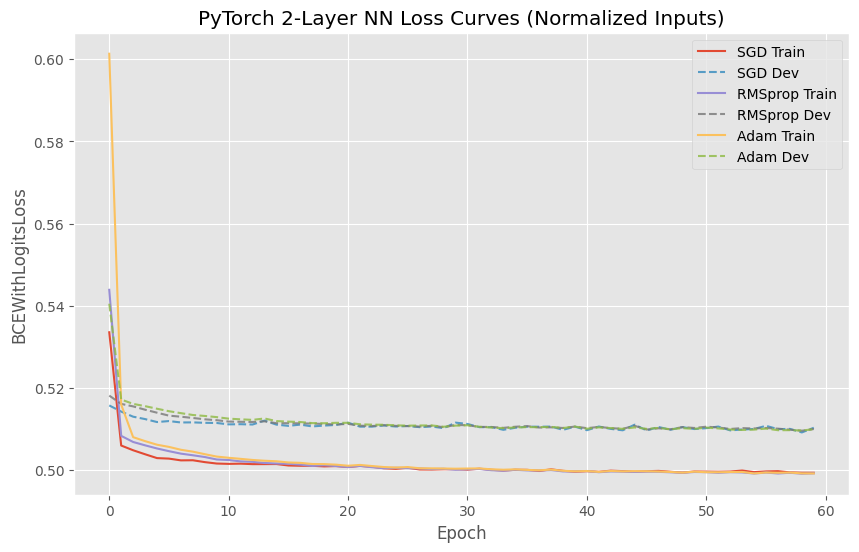

In [21]:
plt.figure(figsize=(10, 6))
for label, hist in optimizer_histories.items():
    plt.plot(hist['train_loss'], label=f'{label} Train')
    plt.plot(hist['dev_loss'], linestyle='--', alpha=0.8, label=f'{label} Dev')

plt.title('PyTorch 2-Layer NN Loss Curves (Normalized Inputs)')
plt.xlabel('Epoch')
plt.ylabel('BCEWithLogitsLoss')
plt.legend()
plt.show()


In [22]:
# Normalization impact experiment (same architecture/optimizer)
norm_results = []

for label, Xtr, Xdv, Xte, lr in [
    ('Unnormalized Inputs', X_train_raw, X_dev_raw, X_test_raw, 0.0007),
    ('Normalized Inputs', X_train_norm, X_dev_norm, X_test_norm, 0.001),
]:
    print(f"\nRunning Adam with {label}...")
    _, result = run_torch_experiment(
        label=label,
        optimizer_name='adam',
        X_train=Xtr,
        y_train=y_train,
        X_dev=Xdv,
        y_dev=y_dev,
        X_test=Xte,
        y_test=y_test,
        hidden_dim=32,
        learning_rate=lr,
        weight_decay=1e-4,
        batch_size=256,
        epochs=60,
        print_every=15,
        seed=RANDOM_SEED,
    )
    norm_results.append({k: v for k, v in result.items() if k != 'history'})

norm_results_df = pd.DataFrame(norm_results).sort_values('test_accuracy', ascending=False)
display(norm_results_df)

best_norm_row = norm_results_df.iloc[0]
print('\nBest normalization setting by test accuracy:')
print(best_norm_row[['label', 'test_accuracy', 'final_test_loss', 'runtime_sec']])



Running Adam with Unnormalized Inputs...
Epoch 1/60 - train loss: 1.109629 - dev loss: 0.811627
Epoch 15/60 - train loss: 0.575035 - dev loss: 0.728330
Epoch 30/60 - train loss: 0.575971 - dev loss: 0.600442
Epoch 45/60 - train loss: 0.553703 - dev loss: 0.531512
Epoch 60/60 - train loss: 0.584852 - dev loss: 0.558031

Running Adam with Normalized Inputs...
Epoch 1/60 - train loss: 0.601354 - dev loss: 0.540533
Epoch 15/60 - train loss: 0.502198 - dev loss: 0.511974
Epoch 30/60 - train loss: 0.500385 - dev loss: 0.510868
Epoch 45/60 - train loss: 0.499787 - dev loss: 0.510431
Epoch 60/60 - train loss: 0.499230 - dev loss: 0.509997


,label,optimizer,hidden_dim,learning_rate,weight_decay,batch_size,epochs,runtime_sec,final_train_loss,final_dev_loss,final_test_loss,train_accuracy,dev_accuracy,test_accuracy,test_precision,test_recall,test_f1
1,Normalized Inputs,adam,32,0.0010,0.0001,256,60,5.867027,0.499037,0.509997,0.513631,0.747020,0.734524,0.735342,0.738771,0.702839,0.720357
0,Unnormalized Inputs,adam,32,0.0007,0.0001,256,60,6.024270,0.561324,0.558031,0.564124,0.736267,0.728525,0.729752,0.701871,0.769750,0.734245



Best normalization setting by test accuracy:
label              Normalized Inputs
test_accuracy               0.735342
final_test_loss             0.513631
runtime_sec                 5.867027
Name: 1, dtype: object


## Task 3 - Hyperparameter Strategy and Rationale

Hyperparameters tuned and rationale:

- **Hidden width**: controls capacity for nonlinear interactions between market features and outcome.
- **Learning rate**: searched on a log scale because training dynamics are highly sensitive to multiplicative LR changes.
- **Optimizer**: SGD/RMSprop/Adam tested because each behaves differently under noisy mini-batch gradients.
- **Weight decay (L2 regularization)**: included to reduce overfitting and stabilize training.
- **Batch size / epochs**: tuned for convergence-speed vs generalization tradeoff.

Below, a random search explores these choices and selects by lowest dev loss (tie-breaker: dev accuracy).


Trial 1/12: opt=sgd, hidden=16, lr=0.00563, wd=0.000088, bs=256, epochs=60
Trial 2/12: opt=adam, hidden=32, lr=0.00055, wd=0.000006, bs=512, epochs=30
Trial 3/12: opt=sgd, hidden=32, lr=0.02371, wd=0.000265, bs=128, epochs=30
Trial 4/12: opt=rmsprop, hidden=32, lr=0.00081, wd=0.000323, bs=256, epochs=60
Trial 5/12: opt=adam, hidden=24, lr=0.00204, wd=0.000199, bs=256, epochs=60
Trial 6/12: opt=sgd, hidden=64, lr=0.08273, wd=0.000301, bs=512, epochs=45
Trial 7/12: opt=sgd, hidden=96, lr=0.06315, wd=0.000039, bs=64, epochs=60
Trial 8/12: opt=sgd, hidden=24, lr=0.02148, wd=0.000010, bs=512, epochs=30
Trial 9/12: opt=sgd, hidden=96, lr=0.00654, wd=0.000637, bs=128, epochs=45
Trial 10/12: opt=sgd, hidden=24, lr=0.04659, wd=0.000007, bs=64, epochs=60
Trial 11/12: opt=adam, hidden=64, lr=0.00050, wd=0.000004, bs=128, epochs=45
Trial 12/12: opt=sgd, hidden=24, lr=0.01219, wd=0.000064, bs=512, epochs=30


,label,optimizer,hidden_dim,learning_rate,weight_decay,batch_size,epochs,runtime_sec,final_train_loss,final_dev_loss,final_test_loss,train_accuracy,dev_accuracy,test_accuracy,test_precision,test_recall,test_f1,trial
0,trial_6,sgd,64,0.082733,0.000301,512,45,4.185752,0.499018,0.509697,0.514389,0.747721,0.740796,0.736160,0.728579,0.726736,0.727657,6
1,trial_5,adam,24,0.002044,0.000199,256,60,5.827438,0.498825,0.509750,0.514148,0.746932,0.736297,0.736569,0.737504,0.709306,0.723130,5
2,trial_11,adam,64,0.000499,0.000004,128,45,5.942701,0.499032,0.510040,0.514067,0.747224,0.738615,0.735751,0.743752,0.694405,0.718232,11
3,trial_9,sgd,96,0.006543,0.000637,128,45,5.669726,0.500279,0.510599,0.514808,0.747575,0.739705,0.738342,0.736295,0.717459,0.726755,9
4,trial_4,rmsprop,32,0.000814,0.000323,256,60,5.692533,0.499541,0.510801,0.514439,0.747224,0.737933,0.736569,0.735303,0.713804,0.724394,4
5,trial_10,sgd,24,0.046589,0.000007,64,60,10.635642,0.500332,0.511058,0.513581,0.746377,0.738069,0.736024,0.742447,0.697779,0.719420,10
6,trial_7,sgd,96,0.063155,0.000039,64,60,9.815985,0.499514,0.511141,0.514889,0.746932,0.737933,0.737660,0.722662,0.745010,0.733666,7
7,trial_3,sgd,32,0.023713,0.000265,128,30,3.477552,0.499694,0.511317,0.513874,0.747487,0.734933,0.739433,0.742630,0.708181,0.724996,3
8,trial_1,sgd,16,0.005630,0.000088,256,60,5.722088,0.501754,0.511810,0.515983,0.747049,0.740524,0.736706,0.734294,0.716334,0.725203,1
9,trial_8,sgd,24,0.021475,0.000010,512,30,2.709291,0.501400,0.512260,0.515592,0.746640,0.738751,0.738478,0.733676,0.723362,0.728482,8



Best random-search configuration (by dev loss):
optimizer             sgd
hidden_dim             64
learning_rate    0.082733
weight_decay     0.000301
batch_size            512
epochs                 45
Name: 0, dtype: object

Best-trial test metrics:
test_accuracy       0.73616
test_precision     0.728579
test_recall        0.726736
test_f1            0.727657
final_test_loss    0.514389
Name: 0, dtype: object


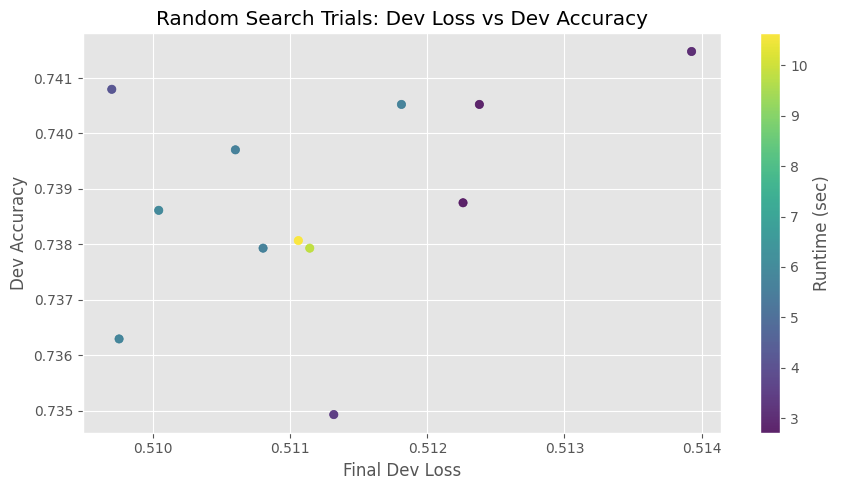

In [23]:
search_rng = np.random.default_rng(RANDOM_SEED + 100)


def sample_config(rng: np.random.Generator) -> Dict[str, object]:
    optimizer = str(rng.choice(['sgd', 'rmsprop', 'adam']))
    hidden_dim = int(rng.choice([16, 24, 32, 48, 64, 96]))

    if optimizer == 'sgd':
        lr = float(10 ** rng.uniform(-2.4, -1.0))
    elif optimizer == 'rmsprop':
        lr = float(10 ** rng.uniform(-3.5, -2.0))
    else:
        lr = float(10 ** rng.uniform(-3.6, -2.1))

    return {
        'optimizer': optimizer,
        'hidden_dim': hidden_dim,
        'learning_rate': lr,
        'weight_decay': float(10 ** rng.uniform(-6.0, -3.0)),
        'batch_size': int(rng.choice([64, 128, 256, 512])),
        'epochs': int(rng.choice([30, 45, 60])),
        'seed': int(rng.integers(1, 1_000_000)),
    }


N_RANDOM_TRIALS = 12
random_trials = []

for trial in range(1, N_RANDOM_TRIALS + 1):
    cfg = sample_config(search_rng)
    print(
        f"Trial {trial}/{N_RANDOM_TRIALS}: opt={cfg['optimizer']}, hidden={cfg['hidden_dim']}, "
        f"lr={cfg['learning_rate']:.5f}, wd={cfg['weight_decay']:.6f}, bs={cfg['batch_size']}, epochs={cfg['epochs']}"
    )

    _, result = run_torch_experiment(
        label=f"trial_{trial}",
        optimizer_name=str(cfg['optimizer']),
        X_train=X_train_norm,
        y_train=y_train,
        X_dev=X_dev_norm,
        y_dev=y_dev,
        X_test=X_test_norm,
        y_test=y_test,
        hidden_dim=int(cfg['hidden_dim']),
        learning_rate=float(cfg['learning_rate']),
        weight_decay=float(cfg['weight_decay']),
        batch_size=int(cfg['batch_size']),
        epochs=int(cfg['epochs']),
        print_every=0,
        seed=int(cfg['seed']),
    )

    row = {k: v for k, v in result.items() if k != 'history'}
    row['trial'] = trial
    random_trials.append(row)

random_search_df = pd.DataFrame(random_trials).sort_values(
    ['final_dev_loss', 'dev_accuracy'],
    ascending=[True, False],
).reset_index(drop=True)

display(random_search_df.head(10))

best_trial = random_search_df.iloc[0]
print('\nBest random-search configuration (by dev loss):')
print(best_trial[['optimizer', 'hidden_dim', 'learning_rate', 'weight_decay', 'batch_size', 'epochs']])
print('\nBest-trial test metrics:')
print(best_trial[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'final_test_loss']])

plt.figure(figsize=(9, 5))
scatter = plt.scatter(
    random_search_df['final_dev_loss'],
    random_search_df['dev_accuracy'],
    c=random_search_df['runtime_sec'],
    cmap='viridis',
    alpha=0.85,
)
plt.colorbar(scatter, label='Runtime (sec)')
plt.xlabel('Final Dev Loss')
plt.ylabel('Dev Accuracy')
plt.title('Random Search Trials: Dev Loss vs Dev Accuracy')
plt.tight_layout()
plt.show()


## Final Notes (Part 2)

This notebook satisfies Part 2 requirements:
- Framework-based 2-layer neural network (PyTorch)
- EDA, train-dev-test split, forward propagation, loss computation, gradient-based training
- Optimizer and normalization experiments
- Hyperparameter strategy and random search with dev-set selection
- Final test-set reporting
